<div Style="text-align: center;line-height: 30px;font-size:32px;font-weight: bold"> Reconocimiento automático de fitolitos</div>
***

En este *notebook* comprobaremos el reconocimiento de fitolitos en una imagen ejemplo, para facilmente comprobar el portencial de nuestro clasificador.

In [20]:
# Imports
import pickle

%matplotlib inline 
#para dibujar en el propio notebook
import numpy as np  #numpy como np
import matplotlib.pyplot as plt #matplotlib como plot

from skimage import io
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.io import imshow

from skimage.feature import daisy

Obtenemos nuestro clasificador

In [21]:
path = '../../rsc/obj/'

cls_path = path + 'cls.sav'
cluster_path = path + 'cluster.sav'

cls = pickle.load(open(cls_path, 'rb'))
cluster = pickle.load(open(cluster_path, 'rb'))

Obtenemos la imagen ejemplo

In [22]:
img_path = '../../rsc/img/Default/2017_5_17_17_54Image_746.jpg'
# img_path = '../../rsc/img/Default/2017_5_17_18_17Image_803.jpg'
# img_path = '../../rsc/img/Default/2017_5_17_16_38Image_483.jpg'
# img_path = '../../rsc/img/Default/2017_5_17_18_9Image_7351.jpg'
# img_path = '../../rsc/img/Default/2017_5_17_15_27Image_100.jpg'
image = rescale(io.imread(img_path), 0.5)
image = rgb2gray(image)

D:\Program Files\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


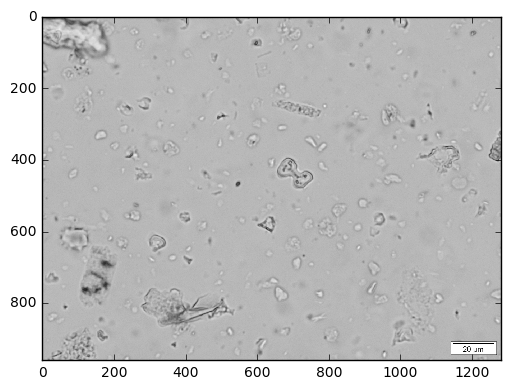

In [23]:
imshow(image)

Definimos algunas funciones necesarias

In [24]:
def predict_image(imgTest):
    global cluster
    global cls
    
    num_centers = len(cluster.cluster_centers_)
    testInstances = []
    
    
    features = daisy(imgTest)
    numFils, numCols, sizeDesc = features.shape
    features = features.reshape((numFils*numCols,sizeDesc))
    
    
    
    pertenencias=cluster.predict(features)
    # extrae histograma
    bovw_representation, _ = np.histogram(pertenencias, bins=num_centers, range=(0,num_centers-1))
    # añade al conjunto de entrenamiento final
    testInstances.append(bovw_representation)
    
    testInstances = np.array(testInstances)
    
    return cls.predict_proba(testInstances)

In [25]:
def sliding_window(image, alto,ancho, stepSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            #print(alto,ancho)
            #print(image[y:y + alto, x:x + ancho].shape)
            yield (x, y, image[y:y + alto, x:x + ancho])
            
            
def predict_window(img):
    probs = predict_image(img)[0]
    #print(probs,probs[0]>0.5)
    #if probs[0]>0.5:
    #    plt.imshow(img)
    
    return probs[1]


#stepSize=60
stepSize=40
# stepSize=70
# alto=280
# ancho=280
alto=150
ancho=150
windowSize = (alto,ancho)

def predict_sliding_window(image, alto,ancho, stepSize):
    #print(alto,ancho, stepSize)
    
    probs = []
    predichas = []
    
    i = 0
    # loop over the sliding window for each layer of the pyramid
    n_winds = 0 
    for (x, y, window) in sliding_window(image, alto, ancho, stepSize):
        #print(window.shape,alto,ancho)
        if window.shape[0] != alto or window.shape[1] != ancho:
            continue
        n_winds+=1
        
    print("hay ",n_winds," ventanas")
    
    for (x, y, window) in sliding_window(image, alto,ancho, stepSize):
    # if the window does not meet our desired window size, ignore it
        if window.shape[0] != alto or window.shape[1] != ancho:
            continue  
        
        
        
        i+=1        
        if i%10==0:
            print("Procesada ventana "+str(i)+" de "+str(n_winds),end="\r")
        
        # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
        # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
        # WINDOW
        prob = predict_window(window)
        if prob>0.5:
            
            probs.append(prob) 
            # x1 ,y1, x2, y2
            box = (x, y, x+ancho, y+alto)
            predichas.append(box)
            
    return probs,np.array(predichas)

In [26]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [27]:
probs0,predichas0 = predict_sliding_window(image, alto,ancho, stepSize)

hay  609  ventanas


In [28]:
probs0 = np.array(probs0)
predichas0 = np.array(predichas0)
predichas0 = predichas0[probs0>0.995]
probs0 = probs0[probs0>0.995]
boxes = non_max_suppression(predichas0, probs=probs0, overlapThresh=0.3)
print(boxes)

[[640 360 790 510]]


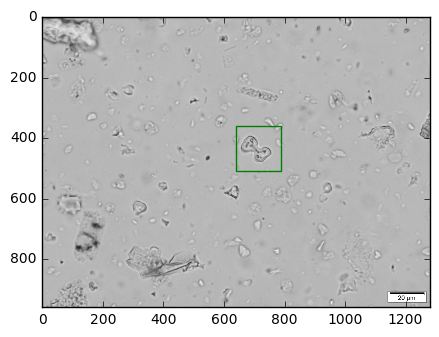

In [29]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111)
ax.imshow(image, cmap=plt.get_cmap('gray'))

for box in boxes:
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0],box[1]),
                             box[2]-box[0],
                             box[3]-box[1],
                             linewidth=1,edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)